# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [41]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [42]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import matplotlib.patches as patches

In [45]:
%%capture
pip install torchray

In [46]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%reload_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'
import cxr_dataset as CXR
import merged_visualize_prediction_no as V
import pandas as pd

env: CUDA_VISIBLE_DEVICES=0


In [47]:
#!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
# %%timeit
 %%capture
!unzip "/content/drive/MyDrive/Prak_MLMI/NIH_CXR14_Resized.zip" -d /content/

## Loading Data and Model

In [94]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'
PATH_TO_IMAGES = "/content/NIH small"
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH_CXR14_Resized/NIH small"
#PATH_TO_IMAGES = prak_dir + "/NIH small"   
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH small"  
MODEL_PATH = prak_dir + '/model/results/checkpoint_best'
PATH_TO_MODEL = prak_dir + '/model/results/checkpoint_best'


dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

POSITIVE_FINDINGS_ONLY=True
LABEL='Cardiomegaly'

dataloader, model= V.load_data(PATH_TO_IMAGES, LABEL, PATH_TO_MODEL, 'BBox', POSITIVE_FINDINGS_ONLY, label_path=label_path)
print("Cases for review:")
print(len(dataloader))



# checkpoint = torch.load(MODEL_PATH, map_location=dev)
# model = checkpoint['model'].module
model.to(dev).eval();
# print(model)

Cases for review:
146


### Insert the bottleneck into the model for NIH

You can experiment with the location of the bottleneck.

In [95]:
iba = IBA(model.features.denseblock2.denselayer6)

In [96]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [97]:
iba.estimate(model, dataloader, device=dev, n_samples=10, progbar=True)

In [98]:
def show_iba(label, img, target, idx, bbox, ax):
    """
    Plots CXR, attribution map of CXR generated by IB 
    """
    img = img[None].to(dev)
    np_img = tensor_to_np_img(img[0])
    iba.reverse_lambda = False
    iba.beta = 0.5
    heatmap = iba.analyze(img, model_loss_closure)  
    # show the heatmap
    plot_saliency_map(heatmap, np_img, ax = ax)
    method = "original IB"
    _ = ax.set_title('{} for category {}'.format(method, label), fontsize=8)






In [99]:
def show_iba_new(label, img, target, idx, bbox, ax):
    """
    Plots CXR, attribution map of CXR generated by IB 
    """
    img = img[None].to(dev)
    np_img = tensor_to_np_img(img[0])
    iba.reverse_lambda = True
    iba.beta = 0.5
    heatmap = iba.analyze(img, model_loss_closure)  
    # show the heatmap
    plot_saliency_map(heatmap, np_img, ax = ax)
    method = "improved IB"
    _ = ax.set_title('{} for category {}'.format(method, label), fontsize=8)


In [100]:
def model_loss_closure(input):
  loss = nn.BCEWithLogitsLoss()
  mse_loss = loss(model(input), torch.tensor(target).view(1,-1).expand(10, -1).to(dev).float())
  return mse_loss

## Compare different methods 

In [101]:
%matplotlib inline

In [110]:
def visualization_comparison():
  # determine rows/columns of the plot, size of each subplot
  size = 6
  rows = 1
  cols = 9

  fig, axes = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
  axes_b = axes.flatten()[-2]
  axes_c = axes.flatten()[-1]
  inputs, labels, filename, bbox, preds = V.plot_map(model, dataloader, LABEL, saliency_layer='features.norm5', axes_a=axes)
  target = labels.squeeze()
  show_iba(LABEL, inputs.squeeze(), target, filename, bbox, axes_b)
  show_iba_new(LABEL, inputs.squeeze(), target, filename, bbox, axes_c)
  plt.show()
  print(preds)


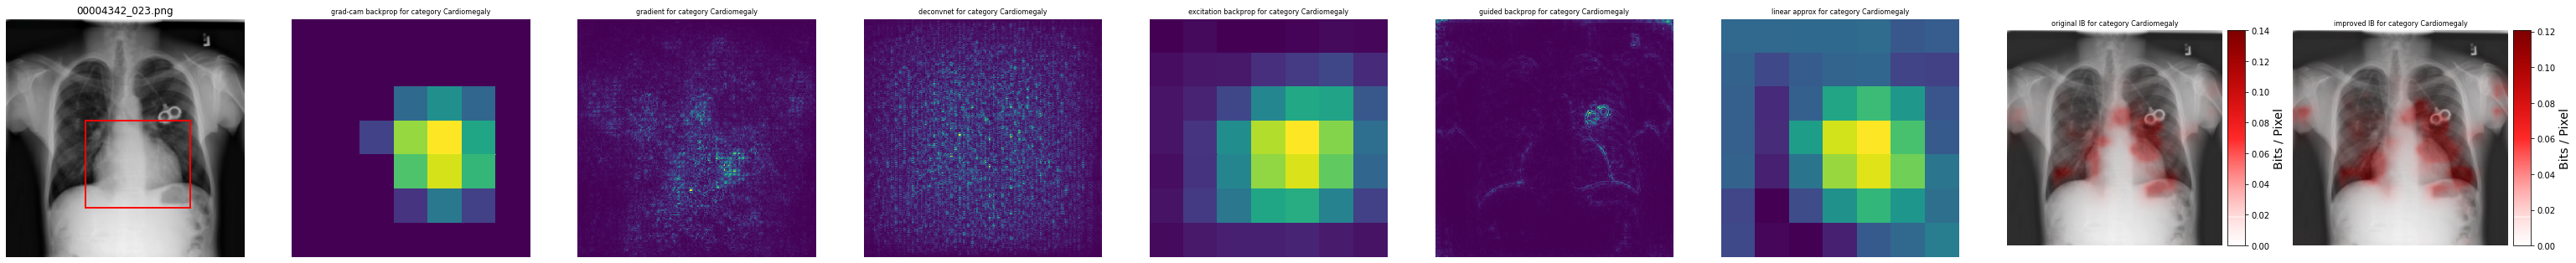

                   Predicted Probability  Ground Truth
Finding                                               
Cardiomegaly                       0.190          True
Infiltration                       0.082         False
Nodule                             0.070         False
Effusion                           0.060         False
Consolidation                      0.013         False
Atelectasis                        0.010         False
Mass                               0.006         False
Pneumonia                          0.005         False
Pleural_Thickening                 0.005         False
Edema                              0.004         False
Pneumothorax                       0.002         False
Fibrosis                           0.002         False
Emphysema                          0.001         False
Hernia                             0.001         False


In [111]:
visualization_comparison()

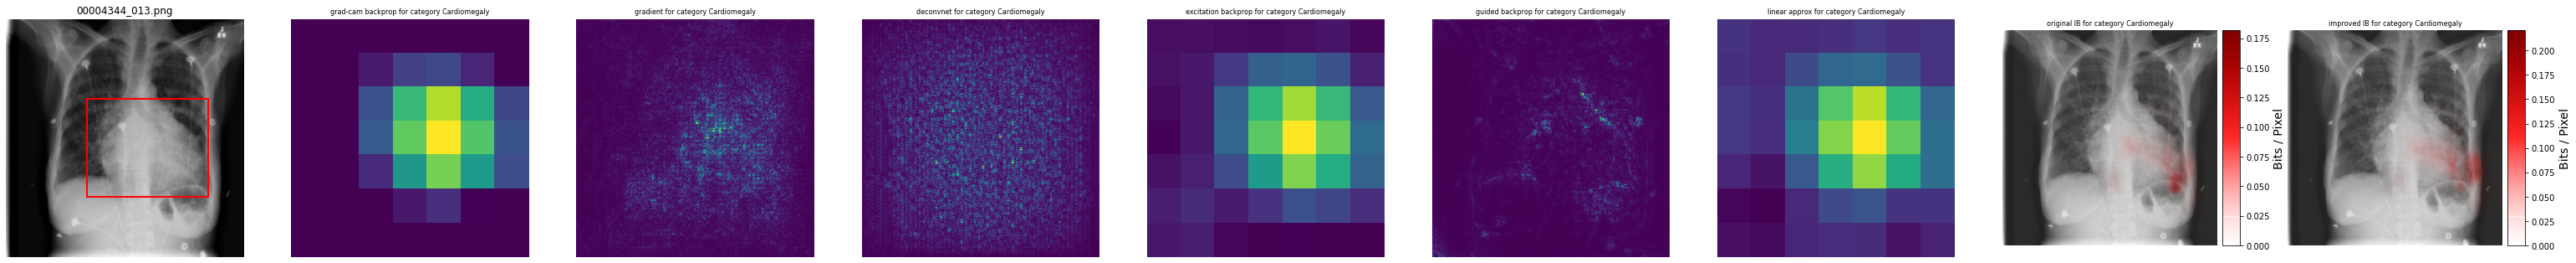

                   Predicted Probability  Ground Truth
Finding                                               
Cardiomegaly                       0.775          True
Infiltration                       0.203         False
Effusion                           0.181         False
Consolidation                      0.102         False
Fibrosis                           0.036         False
Pleural_Thickening                 0.034         False
Nodule                             0.033         False
Pneumonia                          0.030         False
Edema                              0.030         False
Atelectasis                        0.026         False
Mass                               0.010         False
Pneumothorax                       0.005         False
Emphysema                          0.002         False
Hernia                             0.002         False


In [112]:
visualization_comparison()

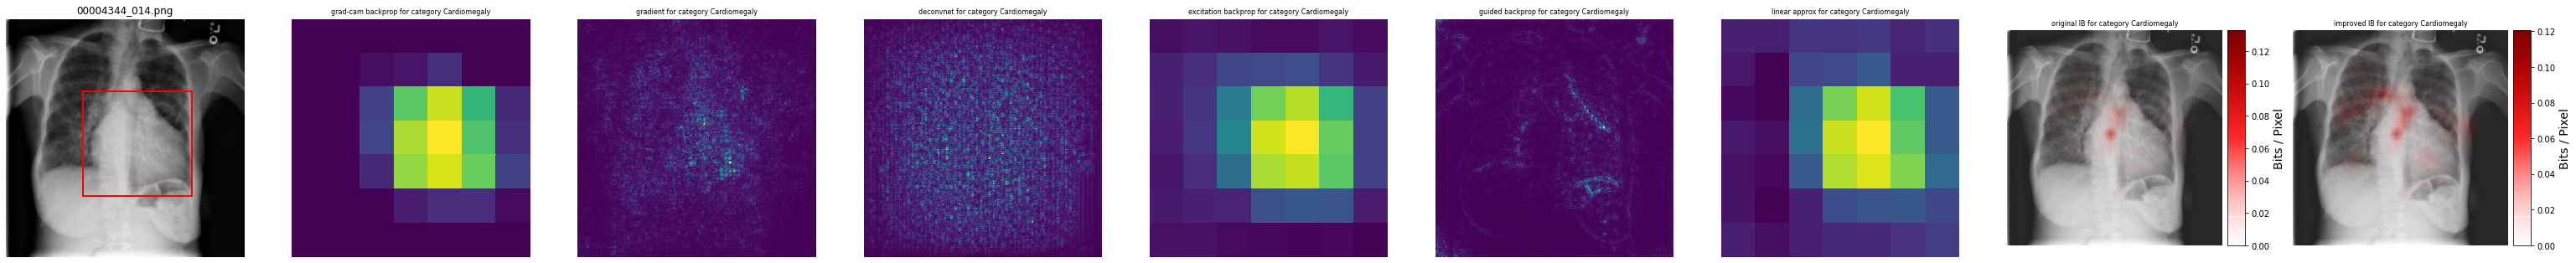

                   Predicted Probability  Ground Truth
Finding                                               
Cardiomegaly                       0.712          True
Infiltration                       0.129          True
Effusion                           0.061         False
Fibrosis                           0.037         False
Edema                              0.028         False
Pneumonia                          0.025         False
Consolidation                      0.025         False
Nodule                             0.020         False
Pleural_Thickening                 0.020         False
Pneumothorax                       0.010         False
Atelectasis                        0.009         False
Mass                               0.002         False
Emphysema                          0.002         False
Hernia                             0.002         False


In [113]:
visualization_comparison()

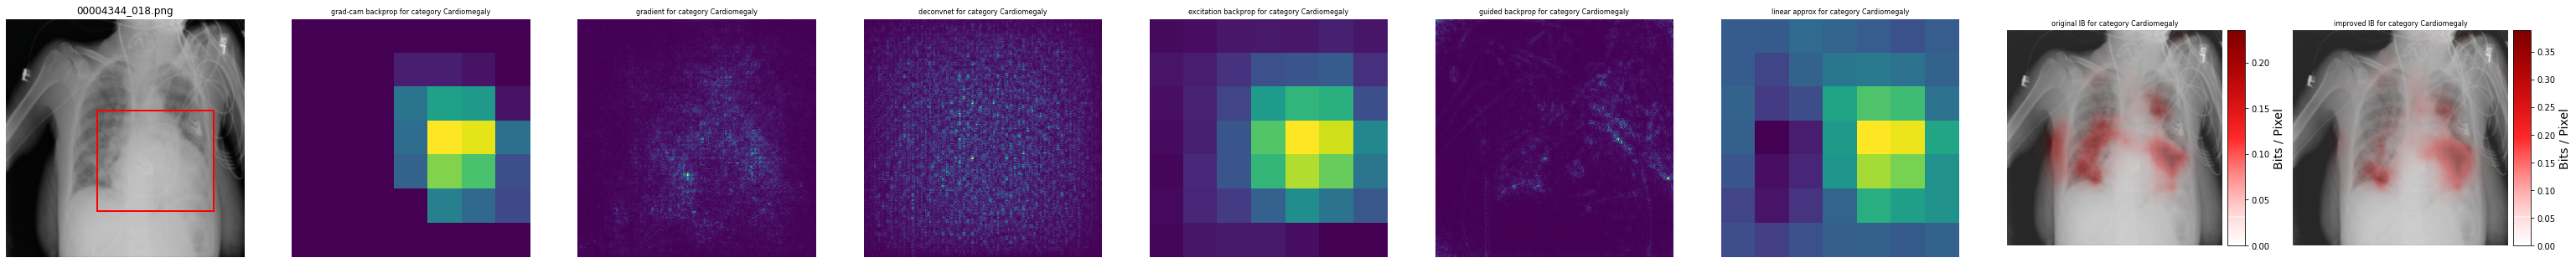

                   Predicted Probability  Ground Truth
Finding                                               
Infiltration                       0.550         False
Cardiomegaly                       0.443          True
Consolidation                      0.141         False
Edema                              0.104         False
Nodule                             0.092         False
Pneumonia                          0.064         False
Atelectasis                        0.033         False
Effusion                           0.028          True
Pneumothorax                       0.012         False
Mass                               0.009         False
Fibrosis                           0.007         False
Pleural_Thickening                 0.005         False
Emphysema                          0.002         False
Hernia                             0.001         False


In [114]:
visualization_comparison()

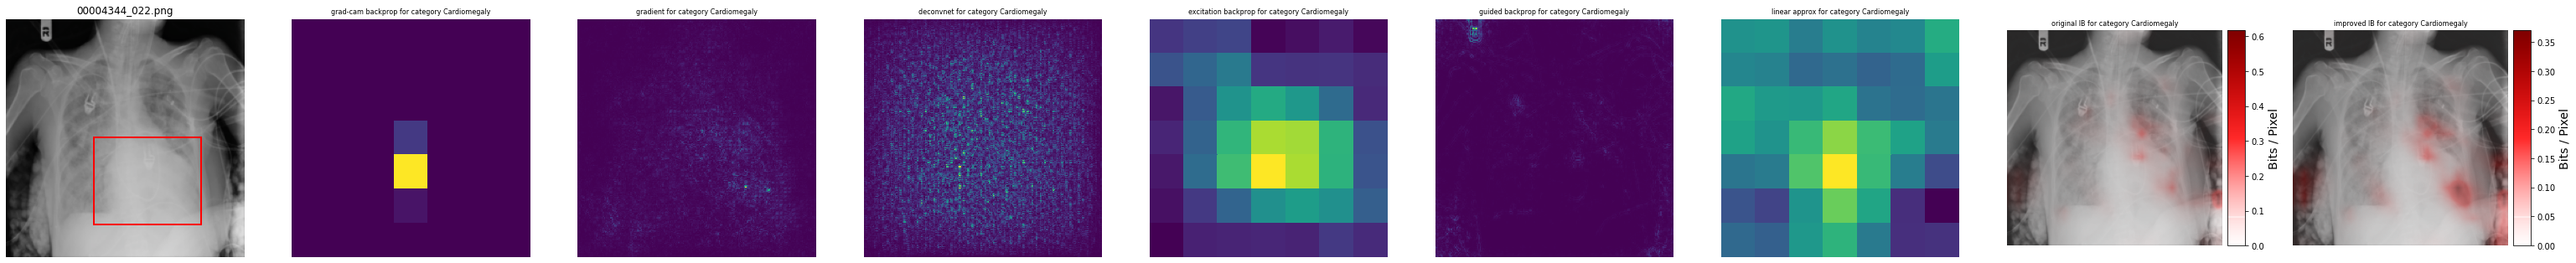

                   Predicted Probability  Ground Truth
Finding                                               
Infiltration                       0.545          True
Edema                              0.174         False
Effusion                           0.082         False
Consolidation                      0.061         False
Nodule                             0.060         False
Emphysema                          0.050         False
Pneumothorax                       0.040         False
Pneumonia                          0.029         False
Cardiomegaly                       0.022          True
Atelectasis                        0.015         False
Pleural_Thickening                 0.004         False
Mass                               0.003         False
Fibrosis                           0.002         False
Hernia                             0.000         False


In [115]:
visualization_comparison()